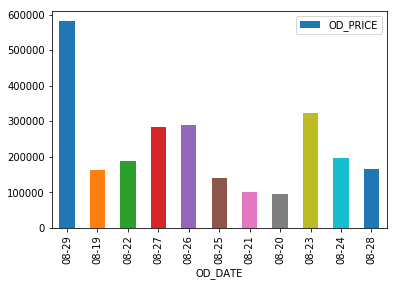

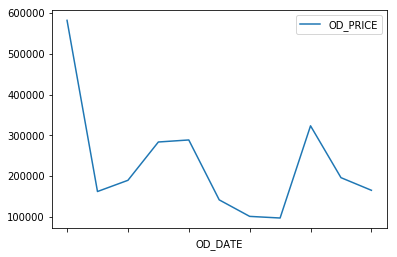

저장완료
     OD_ID  OD_PRICE             OD_DATE
0      2.0     30500 2019-08-27 17:56:33
1      9.0     25000 2019-08-27 18:20:05
2     12.0     25000 2019-08-29 12:17:26
3     13.0     33500 2019-08-29 12:19:32
4     14.0     67000 2019-08-29 12:19:34
5     17.0     25000 2019-08-29 12:25:14
6     18.0         0 2019-08-29 12:26:24
7     19.0         0 2019-08-29 12:27:43
8     21.0     25000 2019-08-29 12:32:48
9     22.0      3500 2019-08-29 12:33:02
10    24.0         0 2019-08-29 12:36:43
11    30.0     30000 2019-08-29 12:47:50
12    32.0      4000 2019-08-29 12:52:51
13    34.0      4000 2019-08-29 12:56:29
14     NaN     10000 2019-08-26 00:00:00
15    35.0     20000 2019-08-19 00:00:00
16    36.0     25000 2019-08-19 00:00:00
17     NaN      3500 2019-08-26 00:00:00
18     NaN      7000 2019-08-26 00:00:00
19     NaN     40500 2019-08-26 00:00:00
20     NaN     30000 2019-08-26 00:00:00
21     NaN     10000 2019-08-26 00:00:00
22     NaN      7000 2019-08-26 00:00:00
23     NaN 

In [81]:
from tkinter import *
from PIL import ImageTk
from PIL import Image
import pandas as pd # pandas import
import matplotlib.pyplot as plt # 시각화 위한 matplotlib import

import cx_Oracle # oracle 연동 위한 import
con = cx_Oracle.connect("KIHYUK/3927@192.168.0.216:1521/orcl") # 연결 설정


root=Tk()
root.geometry("600x800+100+100")
flag=False
Label(root,text=u"Villain Restraurant",font=("Helvetica",20)).place(x=170,y=20)
sel_menu1={1:(u"선택안함",0),2:(u"수프",4000),3:(u"바케트",3500),4:(u"케이준샐러드",5500)}
sel_menu2={1:(u"선택안함",0),2:(u"비프스테이크",25000),3:(u"함박스테이크",30000),4:(u"돈까스",15000)}
sel_menu3={1:(u"선택안함",0),2:(u"에스프레소",4000),3:(u"벨기에와플",3500),4:(u"아이스크림",5000)}
sel_menu={u"에피타이저":sel_menu1,u"메인메뉴":sel_menu2,u"디저트":sel_menu3}
final_selected={1:(u"선택안함",0),2:(u"선택안함",0),3:(u"선택안함",0)}
menu_name={1:u"에피타이저",2:u"메인메뉴",3:u"디저트"}
cost=0
df=None


class menu:
    def __init__(self,number):
        self.number=number
        self.this_menu_name=menu_name.get(number)
        self.var=IntVar()
        self.var.set(1)
        
    def selected(self):
        temp=sel_menu.get(self.this_menu_name).get(self.var.get())[0]
        Label(root,text=u"선택된 메뉴:").place(x=360,y=70+170*(self.number-1))
        Label(root,text=u"선택된 메뉴:"+temp).place(x=360,y=70+170*(self.number-1))
        global final_selected
        final_selected[self.number]=sel_menu.get(self.this_menu_name).get(self.var.get())
    
    def pop_menu(self):
        global menu_1
        menu_1=Toplevel(root)
        menu_1.title(self.this_menu_name)
        y=170*self.number+25
        #여기서 문제 발생
        menu_1.geometry("250x100+110+%d" % (y))
        for i in sel_menu.get(self.this_menu_name):
            Radiobutton(menu_1,text=sel_menu.get(self.this_menu_name).get(i)[0],variable=self.var,value=i,indicatoron=0,command=self.selected).pack(fill=X)

            
def make_menu(number):
    global this_menu
    this_menu=menu(number)         
    this_menu.pop_menu() 

def reciept(): # 영수증(csv저장) 함수
    df=pd.read_sql("select * from order_menu", con=con) #pandas 
    df.to_csv("csv 저장") #db에 내용을 dataframe형태로 불러와 csv로 변환하여 저장
    print("저장완료")
    
def order(): # 주문 함수
    global v
    global flag
    ordering=Toplevel(root)
    global cost
    global df
    for i in final_selected:
        cost+=final_selected[i][1]
    
    for i in menu_name:
        Label(ordering,text=menu_name.get(i)+':').grid(row=i,column=1)
        Label(ordering,text=final_selected.get(i)[0]).grid(row=i,column=3)
        Label(ordering,text=final_selected.get(i)[1]).grid(row=i,column=5)
    
    Label(ordering,text=u"총 계산금액=" + str(cost) + u"원 입니다.").grid(row=4,column=2)
    ## Oracle에 총 판매금액 저장
    cursor=con.cursor()
    cursor.execute("INSERT INTO ORDER_MENU(OD_ID,OD_PRICE,OD_DATE) VALUES(seq1.nextval,:ct,sysdate)",ct=cost) # oracle insert
    
    df = pd.read_sql("select * from order_menu", con=con) # 불러온 데이터프레임 확인용 global변수로 줘서 함수밖에서 출력할것임
    con.commit()
    con.close()
    
    return df
   
def sales(): # 매출시각화 함수
    # pandas 라이브러리 활용해 데이터베이스의 테이블을 데이터프레임 형태로 불러옴
    df = pd.read_sql("SELECT SUM(OD_PRICE) OD_PRICE, OD_DATE FROM(select od_price,to_char(od_date, 'MM-DD') OD_DATE from order_menu) GROUP BY OD_DATE",con=con)
    # 불러온 데이터프레임을 토대로 시각화(plot 차트)
    df.plot(x='OD_DATE', y='OD_PRICE',kind='bar')
    df.plot(x='OD_DATE', y='OD_PRICE')
    plt.show()

    
mymenu=menu(root)
Button(root,text=u"에피타이저",command=lambda: make_menu(1)).place(x=10,y=70)
Button(root,text=u"메인메뉴",command=lambda: make_menu(2)).place(x=10,y=210)  
Button(root,text=u"디저트",command=lambda: make_menu(3)).place(x=10,y=350)
Button(root,text=u"영수증출력",command=reciept).place(x=370,y=650) # 버튼별 함수 지정
Button(root,text=u"매출현황",command=sales).place(x=440,y=650) # 버튼별 함수 지정
Button(root,text=u"주문하기",command=order).place(x=500,y=650) # 버튼별 함수 지정

images=[(1,"1.jpg"),(2,"2.jpg"),(3,"3.jpg")]

for i,image in images:
    img=Image.open(image)
    this_image=ImageTk.PhotoImage(img)
    mylabel=Label(image=this_image)
    mylabel.image=this_image
    mylabel.place(x=100,y=70+(i-1)*130)
root.config(width=600,height=800,background="seashell3")
root.title(u"Restaurant of Amigo")
root.mainloop()

print(df) # 주문함수내에서 불러온 현재 db의 테이블을 데이터프레임으로 가져옴